<a href="https://colab.research.google.com/github/AlexxLai/ml0716/blob/master/01lymphoma_CNN_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

In [14]:
IMG_SIZE = 256
class_map = {'CLL':0, 'MCL': 1, 'FL': 2}

In [19]:
# Read single image
data_path = 'drive/My Drive/Day4/lymphoma/*/*.tif' 
img_paths = glob(data_path)
img_paths = np.random.choice(img_paths, 100) # 100 images only for demo

print('number of images', len(img_paths))

number of images 100


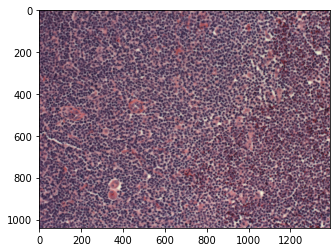

In [23]:
img = cv2.imread(img_paths[0])[:,:,::-1] # BGR -> RGB
plt.imshow(img)

((1040, 1388, 3), (256, 256, 3))

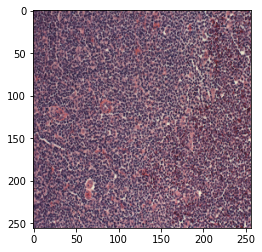

In [21]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [24]:
# Extract img class
img_path = img_paths[0]
img_path

'drive/My Drive/Day4/lymphoma/MCL/sj-04-4525-R4_004.tif'

In [25]:
cls = img_path.split('/')[-2]
cls

'MCL'

In [26]:
class_map[cls]

1

In [36]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [37]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)[:,:,::-1] # BGR -> RGB
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_resize = img_resize / 255. # normalize 0~255 -> 0~1
    
    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [39]:
# label count
unique_classes, counts = np.unique(y, return_counts=True)
unique_classes, counts

(array([0., 1., 2.]), array([29, 37, 34]))

In [40]:
# One-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=3)

In [41]:
# Split training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 256, 256, 3), (20, 256, 256, 3), (80, 3), (20, 3))

### Build model

In [ ]:
# model 1
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = Conv2D(filters=17, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Conv2D(filters=31, kernel_size=3, activation='relu')(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=inputs, outputs=prediction)

In [ ]:
# model2
model2 = tf.keras.models.Sequential()
model2.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
model2.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
model2.add(Conv2D(filters=17, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(filters=31, kernel_size=3, activation='relu'))
model2.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(3, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
# show model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
logs = model.fit(X_train, y_train,
                batch_size=16,
                epochs=50,
                verbose=1,
                validation_data=(X_test, y_test))

In [ ]:
history = logs.history

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

### Metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model_pred = model.predict(X_test)
y_pred = np.argmax(model_pred, axis=-1)

y_true = np.argmax(y_test, axis=-1)
print(y_true.shape, y_pred.shape)
print('ground truth: ', y_true[:5])
print('model pred: ', y_pred[:5])

In [ ]:
# classification_report
target_names = ['CLL', 'MCL', 'FL']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# confusion_matrix
# row: ground truth class
# column: prediction class
print(confusion_matrix(y_true, y_pred))